In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import numpy as np
from tomso import fgong
# from matplotlib import pyplot as pl
import pandas as pd

In [3]:
s = fgong.load_fgong('data/fgong.l5bi.d.15c', G=6.67232e-8, return_object=True)

In [4]:
plt.style.use('science')

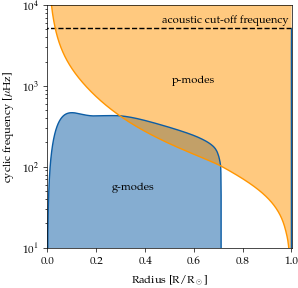

In [37]:
# plt.figure(figsize=[6.3/2, 6.3/2])

# N = np.ones_like(s.N2)*1e-50
# N[s.N2>0] = np.sqrt(s.N2[s.N2>0])/2./np.pi
# S = [np.sqrt(1.*l*(l+1)*s.cs2/s.r**2)/2./np.pi for l in [1,15]]

# plt.plot([-1,2], [5.2e3, 5.2e3], 'k--')
# line, = plt.semilogy(s.x, N*1e6, c='C0') # g modes?
# plt.fill_between(s.x, 1e-99, N*1e6, facecolor=line.get_color(), alpha=0.5)
# for Si in S[:1]:
#     line, = plt.semilogy(s.x, Si*1e6, c='C2')
#     plt.fill_between(s.x, Si*1e6, 1e99, facecolor=line.get_color(), alpha=0.5)

# plt.text(0.6, 10.**3., 'p-modes', fontsize=8,
#             horizontalalignment='center',
#             verticalalignment='bottom')
# # plt.text(0.8, 10.**3.33, '$\ell=15$ pressure modes', fontsize=9,
# #             horizontalalignment='center',
# #             verticalalignment='center')
# plt.text(0.35, 10.**1.75, 'g-modes', fontsize=8,
#             horizontalalignment='center',
#             verticalalignment='center')
# plt.text(0.99, 5.5e3, 'acoustic cut-off frequency', fontsize=8,
#         horizontalalignment='right',
#         verticalalignment='bottom')
    
# plt.axis([0., np.max(s.x), 1e1, 1e4])
# plt.xlabel(f'Radius [R/R$_\odot$]')
# plt.ylabel('cyclic frequency [$\mu$Hz]')

# plt.savefig('propagation_diagram.pdf', dpi=300, bbox_inches='tight', pad_inches=0.)

<ipython-input-22-8c428e3c083f>:25: RuntimeWarning: invalid value encountered in sqrt
  k_r = np.sqrt(k_r2)
<ipython-input-22-8c428e3c083f>:41: RuntimeWarning: invalid value encountered in sqrt
  /np.sqrt(np.interp(ri, S.r[::-1], k_r2[::-1], left=np.nan, right=np.nan)),
<ipython-input-22-8c428e3c083f>:25: RuntimeWarning: invalid value encountered in sqrt
  k_r = np.sqrt(k_r2)
<ipython-input-22-8c428e3c083f>:41: RuntimeWarning: invalid value encountered in sqrt
  /np.sqrt(np.interp(ri, S.r[::-1], k_r2[::-1], left=np.nan, right=np.nan)),


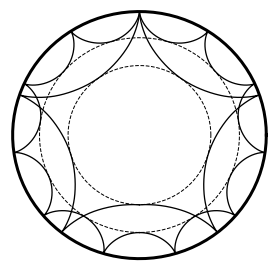

In [22]:
# formulae from http://soi.stanford.edu/papers/dissertations/giles/thesis/PDF/chapter02.pdf

import numpy as np
from matplotlib import pyplot as pl
from scipy import integrate as spint

TAU = 2.*np.pi
th_right = 0.5*TAU
th_left = 0.5*TAU

S = fgong.load_fgong('data/fgong.l5bi.d.15c', G=6.67232e-8, return_object=True)
omega = 4*TAU*1e-3

omega_AC2 = S.cs2/4./S.Hp**2

t = np.linspace(0., 10000., 100000)/S.R
x0 = [0.9995*S.R, TAU/4.]

plt.figure(figsize=[5, 5])

# [2, 20, 25, 75]
for ell in [35, 75]:
    k_h = np.sqrt(1.0*ell*(ell+1))/S.r
    k_r2 = (omega**2-omega_AC2)/S.cs2 - k_h**2*(1.-S.N2/omega**2)
    k_r = np.sqrt(k_r2)

    v_gr = k_r*omega**3*S.cs2/(omega**4-k_h**2*S.cs2*S.N2)  # dlnr
    v_gh = k_h*omega*S.cs2*(omega**2-S.N2)/(omega**4-k_h**2*S.cs2*S.N2)  # dtheta
    v_gr_k_r = k_r2*omega**3*S.cs2/(omega**4-k_h**2*S.cs2*S.N2)

    # I = (np.isfinite(v_gr*v_gh))
    # v_gr = v_gr[I]
    # v_gh = v_gh[I]
    # r = r[I]

    # RHS of dlnr/ds, dtheta/ds
    def v(x, t, sign=(-1,-1)):
        ri, thi = x
        # return [sign[0]*ri*np.interp(ri, r[::-1], v_gr[::-1], left=np.nan, right=np.nan),
        return [sign[0]*ri*np.interp(ri, S.r[::-1], v_gr_k_r[::-1], left=np.nan, right=np.nan) \
                /np.sqrt(np.interp(ri, S.r[::-1], k_r2[::-1], left=np.nan, right=np.nan)),
                sign[1]*np.interp(ri, S.r[::-1], v_gh[::-1], left=np.nan, right=np.nan)]

    sol = spint.odeint(v, x0, t, args=((-1,-1),))

    s, th = sol.T
    I = np.isfinite(s*th)
    s = s[I]
    th = th[I]

    # truncates solutions that accidentally converge on dtheta/dr=0
    I = np.where(np.diff(th)/np.diff(s)<0.)[0]
    if len(I)>0:
        s = s[:I[0]]
        th = th[:I[0]]
    
    # this completes one arc, which we then store
    th = np.hstack((th, 2.*th[-1]-th[::-1]))
    s = np.hstack((s, s[::-1]))

    th_one = np.copy(th)
    s_one = np.copy(s)
    
    # to make the complete arc (with bounces), we add more arcs until
    # we get to the desired angle, then cut everything up to that
    # angle

    # first clockwise
    for i in range(100):
        if np.abs(th[-1]-th[0]) < th_right:
            th = np.hstack((th, th_one-th[0]+th[-1]))
            s = np.hstack((s, s_one))
        else:
            s = s[np.abs(th-th[0]) < th_right]
            th = th[np.abs(th-th[0]) < th_right]
            break
    
    x = s*np.cos(th)/S.R
    y = s*np.sin(th)/S.R
    arc, = plt.plot(x, y, c='k', lw=1.3)

#     plt.arrow(x[-2], y[-2], x[-1]-x[-2], y[-1]-y[-2],
#              color=arc.get_color(), width=0.01)

    # then counter-clockwise
    th_one = 2.*th_one[0]-th_one
    th = np.copy(th_one)
    s = np.copy(s_one)

    for i in range(100):
        if np.abs(th[-1]-th[0]) < th_left:
            th = np.hstack((th, th_one-th[0]+th[-1]))
            s = np.hstack((s, s_one))
        else:
            s = s[np.abs(th-th[0]) < th_left]
            th = th[np.abs(th-th[0]) < th_left]
            break
    
    x = s*np.cos(th)/S.R
    y = s*np.sin(th)/S.R
    arc, = plt.plot(x, y, color=arc.get_color(), lw=1.3)

#     plt.arrow(x[-2], y[-2], x[-1]-x[-2], y[-1]-y[-2],
#              color=arc.get_color(), width=0.01)
        
    # then dashed circle for inner turning point
    th = np.linspace(0., TAU, 100)
    s_t = np.interp(0., S.cs2-omega**2/ell/(ell+1)*S.r**2, S.r)
    x = s_t*np.cos(th)/S.R
    y = s_t*np.sin(th)/S.R
    plt.plot(x, y, '--', color=arc.get_color())
    
th = np.linspace(0., TAU, 100)
s = np.ones(len(th))
x = s*np.cos(th)
y = s*np.sin(th)
    
plt.plot(x, y, 'k-', lw=3)
# b = args.padding
# plt.subplots_adjust(top=1-b, bottom=b, left=b, right=1-b)
plt.axis('off')

plt.savefig('front_image.pdf', dpi=300, bbox_inches='tight', pad_inches=0.)

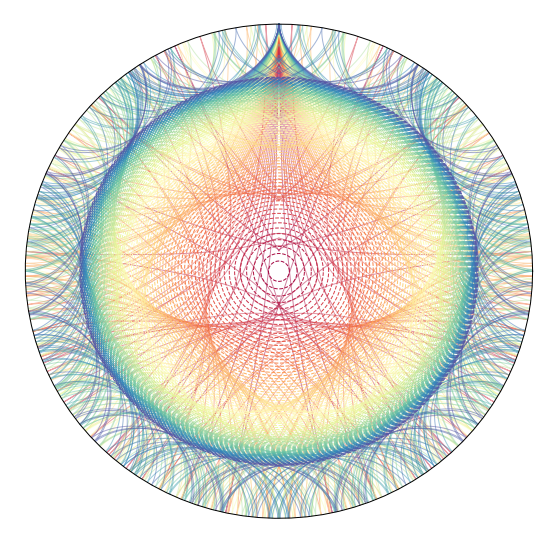

In [61]:
# formulae from http://soi.stanford.edu/papers/dissertations/giles/thesis/PDF/chapter02.pdf

import numpy as np
np.seterr(divide='ignore', invalid='ignore')
from matplotlib import pyplot as pl
from scipy import integrate as spint
import seaborn as sns

plt.figure(figsize=[10,10])

TAU = 2.*np.pi
th_right = 1*TAU
th_left = 1*TAU

S = fgong.load_fgong('data/fgong.l5bi.d.15c', G=6.67232e-8, return_object=True)
omega = 4*TAU*1e-3

omega_AC2 = S.cs2/4./S.Hp**2

t = np.linspace(0., 500000., 100000)/S.R
x0 = [0.9995*S.R, TAU/4.]

# [2, 20, 25, 75]
ells = range(1, 75)
colors = sns.color_palette("Spectral", len(ells))
for ell, color in zip(range(1, 75), colors):
    k_h = np.sqrt(1.0*ell*(ell+1))/S.r
    k_r2 = (omega**2-omega_AC2)/S.cs2 - k_h**2*(1.-S.N2/omega**2)
    k_r = np.sqrt(k_r2)

    v_gr = k_r*omega**3*S.cs2/(omega**4-k_h**2*S.cs2*S.N2)  # dlnr
    v_gh = k_h*omega*S.cs2*(omega**2-S.N2)/(omega**4-k_h**2*S.cs2*S.N2)  # dtheta
    v_gr_k_r = k_r2*omega**3*S.cs2/(omega**4-k_h**2*S.cs2*S.N2)

    # I = (np.isfinite(v_gr*v_gh))
    # v_gr = v_gr[I]
    # v_gh = v_gh[I]
    # r = r[I]

    # RHS of dlnr/ds, dtheta/ds
    def v(x, t, sign=(-1,-1)):
        ri, thi = x
        rep = np.nan
        # return [sign[0]*ri*np.interp(ri, r[::-1], v_gr[::-1], left=np.nan, right=np.nan),
        return [sign[0]*ri*np.interp(ri, S.r[::-1], v_gr_k_r[::-1], left=rep, right=rep) \
                /np.sqrt(np.interp(ri, S.r[::-1], k_r2[::-1], left=rep, right=rep)),
                sign[1]*np.interp(ri, S.r[::-1], v_gh[::-1], left=rep, right=rep)]

    sol = spint.odeint(v, x0, t, args=((-1,-1),))

    s, th = sol.T
    I = np.isfinite(s*th)
    s = s[I]
    th = th[I]

    # truncates solutions that accidentally converge on dtheta/dr=0
    I = np.where(np.diff(th)/np.diff(s)<0.)[0]
    if len(I)>0:
        s = s[:I[0]]
        th = th[:I[0]]
    
    # this completes one arc, which we then store
    th = np.hstack((th, 2.*th[-1]-th[::-1]))
    s = np.hstack((s, s[::-1]))

    th_one = np.copy(th)
    s_one = np.copy(s)
    
    # to make the complete arc (with bounces), we add more arcs until
    # we get to the desired angle, then cut everything up to that
    # angle

    # first clockwise
    for i in range(100):
        if np.abs(th[-1]-th[0]) < th_right:
            th = np.hstack((th, th_one-th[0]+th[-1]))
            s = np.hstack((s, s_one))
        else:
            s = s[np.abs(th-th[0]) < th_right]
            th = th[np.abs(th-th[0]) < th_right]
            break
    
    x = s*np.cos(th)/S.R
    y = s*np.sin(th)/S.R
    arc, = plt.plot(x, y, c=color, alpha=0.5)

#     plt.arrow(x[-2], y[-2], x[-1]-x[-2], y[-1]-y[-2],
#              color=arc.get_color(), width=0.01)

    # then counter-clockwise
    th_one = 2.*th_one[0]-th_one
    th = np.copy(th_one)
    s = np.copy(s_one)

    for i in range(100):
        if np.abs(th[-1]-th[0]) < th_left:
            th = np.hstack((th, th_one-th[0]+th[-1]))
            s = np.hstack((s, s_one))
        else:
            s = s[np.abs(th-th[0]) < th_left]
            th = th[np.abs(th-th[0]) < th_left]
            break
    
    x = s*np.cos(th)/S.R
    y = s*np.sin(th)/S.R
    arc, = plt.plot(x, y, color=arc.get_color(), alpha=0.5)

#     plt.arrow(x[-2], y[-2], x[-1]-x[-2], y[-1]-y[-2],
#              color=arc.get_color(), width=0.01)
        
    # then dashed circle for inner turning point
    th = np.linspace(0., TAU, 100)
    s_t = np.interp(0., S.cs2-omega**2/ell/(ell+1)*S.r**2, S.r)
    x = s_t*np.cos(th)/S.R
    y = s_t*np.sin(th)/S.R
    plt.plot(x, y, '--', color=arc.get_color())
    
th = np.linspace(0., TAU, 100)
s = np.ones(len(th))
x = s*np.cos(th)
y = s*np.sin(th)
    
plt.plot(x, y, 'k-')
# b = args.padding
# plt.subplots_adjust(top=1-b, bottom=b, left=b, right=1-b)
plt.axis('off')
plt.show()